Credit: Code and references for this program are directly taken from/inspired by pages from the textbook "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems by Aurelien Geron", second edition AND third edition

In [1]:
# Fetch data to be used for ML Prediction Model development

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def loadHousingData():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [2]:
housing = loadHousingData()
# Look at the first few rows of data to get an idea of the structure
housing.head()

C:\Users\Chloe Wei\AppData\Local\Temp\ipykernel_262744\3526692123.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Get quick description of data (i.e. num of rows, type of each attribute, etc.)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# See the different categories and count how many districts fall into each category for the ocean_proximity categorical attribute
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

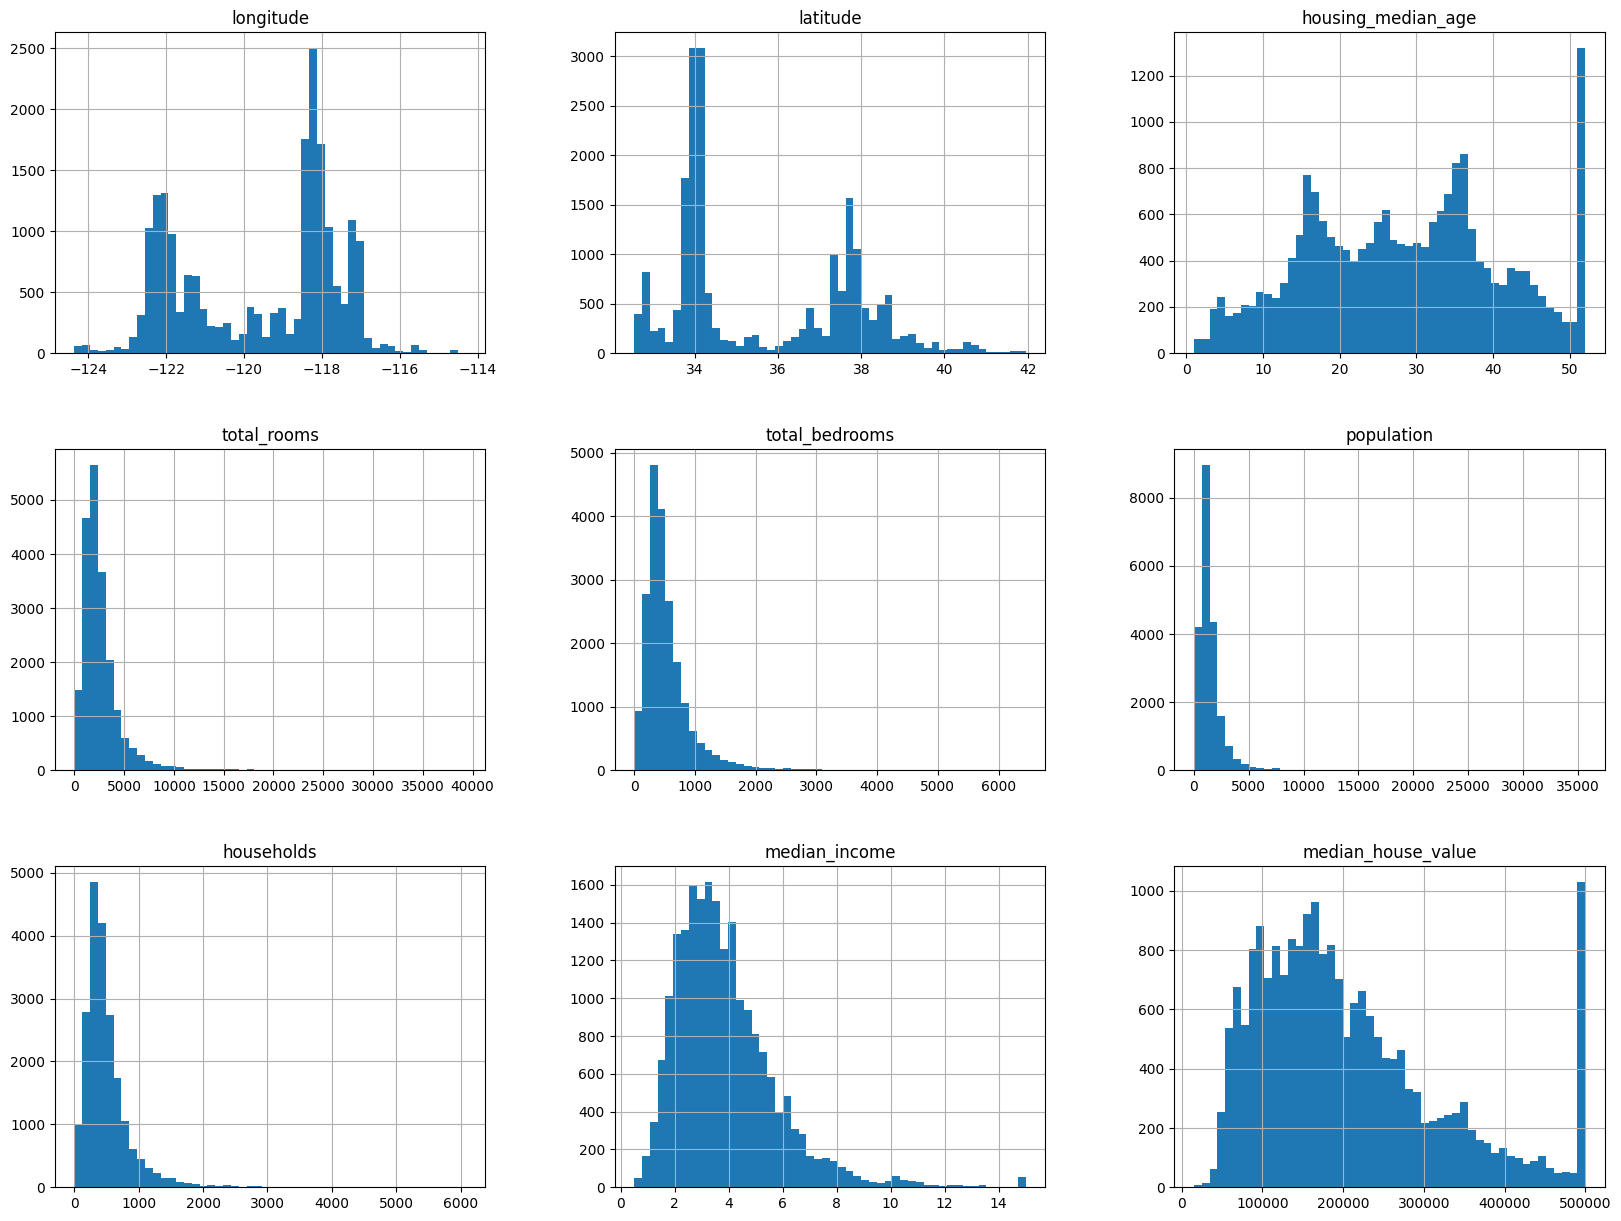

In [5]:
# Histogram of each features
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Diagrams demonstrating the count for different attributes as provided in the dataset

Note that median income is scaled; 1 represents 10, 000 and so on and so forth

In [6]:
# Function to create test set and training set by splitting provided data by user-provided ratio
import numpy as np
def split_train_test(data, test_ratio):
    # Shuffle data to maximize chances of getting truly random sample of data
    shuffled_indices = np.random.permutation(len(data))
    # Set desired size of the test data
    test_set_size = int(len(data) * test_ratio)
    # Split given data into test and training data via indices
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
# Split data into testing and training data
train_set, test_set = split_train_test(housing, 0.2)

In [17]:
# Alternative way to split data set into training and test data via built-in function
# Identical to function above except also allows you to set a random generator seed to ensure the data is split the same way every time it is run
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Mimicked scenario: Told that median income is an important indicator of median housing price. Then accordingly use stratified sampling to make sure that the test set is representative of the income categories of people in the entire dataset to properly see how accurate trained model is:

<Axes: >

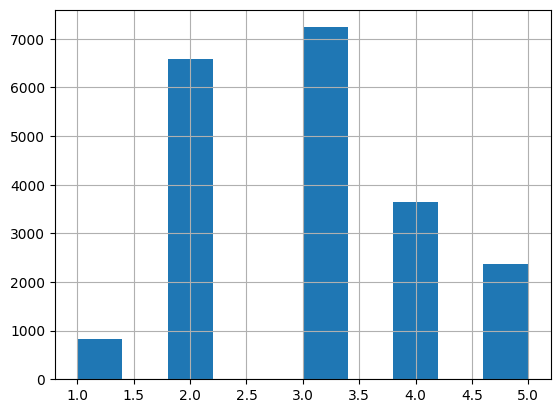

In [ ]:
# Split full data set into 5 income category intervals to see spread of median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Display results in histogram
housing["income_cat"].hist()

<Axes: >

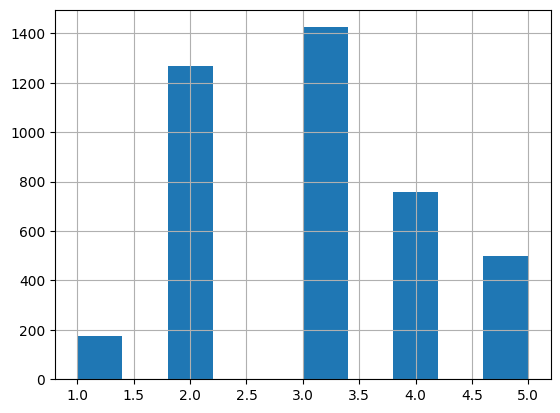

In [20]:
# Split test data set into 5 income category intervals to see spread of median income
test_set["income_cat"] = pd.cut(test_set["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Display results in histogram
test_set["income_cat"].hist()

In [21]:
# Use SK-learn's built-in Stratified ShuffleSplit class to do the stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
# See if stratified sampling works by comparing if it produces a test set with median income proportions closer to the actual full dataset median income proportions than with a random sampling test dataset
# Stratified sampling
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [26]:
# All data
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [27]:
# Random sampling
test_set["income_cat"].value_counts() / len(housing)

income_cat
3    0.069041
2    0.061483
4    0.036822
5    0.024176
1    0.008479
Name: count, dtype: float64

Clearly, stratified sampling produces a test set with proportions most representative of those in the full data set compared to a randomly generated test set

In [30]:
# Remove the income_cat attribute from the stratified sampling training and test set so that the data can return to its original state
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

In [37]:
# Test training set based on data given to play around without worrying about harming the training set (and my flowers)
# Create copy of data set so can play around it as many times as you ant it:

housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

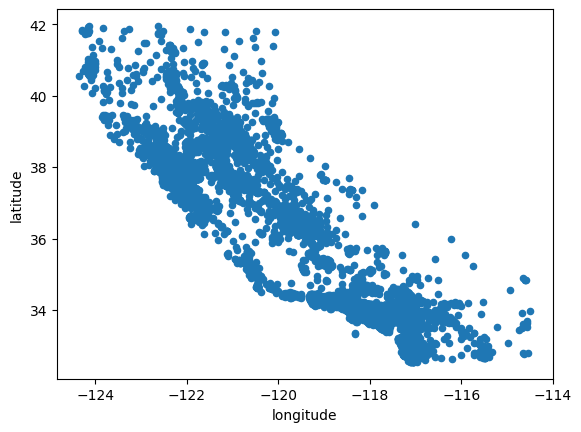

In [41]:
# Visualize the data
housing.plot(kind="scatter", x="longitude", y="latitude")